# Task 1. Default Delay-Match-To-Sample (DMTS):

[This notebook implements task 1 as well, also using MNIST images. However this time the

A) Encoding of tasks

b) Model architecure

are different]

A sample image is presented and then, after a time delay of arbitrary duration, a test image is presented. The
goal is to evaluate the model's ability to retain the sample image in working memory during the delay period
and compare it to the test image. To titrate difficulty, the similarity between sample and test images can be
varied, and the model's invariance to image transformations and zero-shot generalization ability will also be
evaluated.


This notebook is structured as follows : 
1. Load task 1 and visualize it
2. Train (and evaluate/validate) a new architecture


[The two key differences with previous approaches are : 

a. Every time step (every image) has an associated label

b. The model produces one output per time step (per image)

]

In [6]:
import os
import numpy as np
from array import array
import matplotlib.pyplot as plt
import importlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms

from sklearn.metrics import accuracy_score

# Custom functions and modules
from auxFuns.utils.process_images import *
from auxFuns.data_funs.task_loading import *
from auxFuns.data_funs.task_visualizing import *

In [4]:
# Reload the packages
import auxFuns.utils.process_images
importlib.reload(auxFuns.utils.process_images)

import auxFuns.data_funs.task_loading
importlib.reload(auxFuns.data_funs.task_loading)

import auxFuns.data_funs.task_visualizing
importlib.reload(auxFuns.data_funs.task_visualizing)

<module 'auxFuns.data_funs.task_visualizing' from '/Users/angelglh/Documents/github_angelglh/working_memory/auxFuns/data_funs/task_visualizing.py'>

In [2]:
# import os
# os.chdir('..')
os.getcwd()

'/Users/angelglh/Documents/github_angelglh/working_memory'

## 1. Load (and visualize) task 1

In [7]:
raw_MNIST = os.getcwd() + '/data/MNIST/raw'

# Training data
training_MNIST = task1_Dataset_MNIST(is_train_data = True, 
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/train-images-idx3-ubyte', raw_MNIST + '/train-labels-idx1-ubyte')
                    )

training_loader_MNIST = DataLoader(training_MNIST, batch_size=64, shuffle=True)


# Training and validation data

testing_all_MNIST = task1_Dataset_MNIST(is_train_data = False, 
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/t10k-images-idx3-ubyte', raw_MNIST + '/t10k-labels-idx1-ubyte')
                    )

test_size = len(testing_all_MNIST) //2
testing_MNIST, valid_MNIST = random_split(testing_all_MNIST, [test_size, len(testing_all_MNIST) - test_size])

testing_loader_MNIST = DataLoader(testing_MNIST, batch_size=64, shuffle=True)
valid_loader_MNIST = DataLoader(valid_MNIST, batch_size=64, shuffle=True)


Training data ...


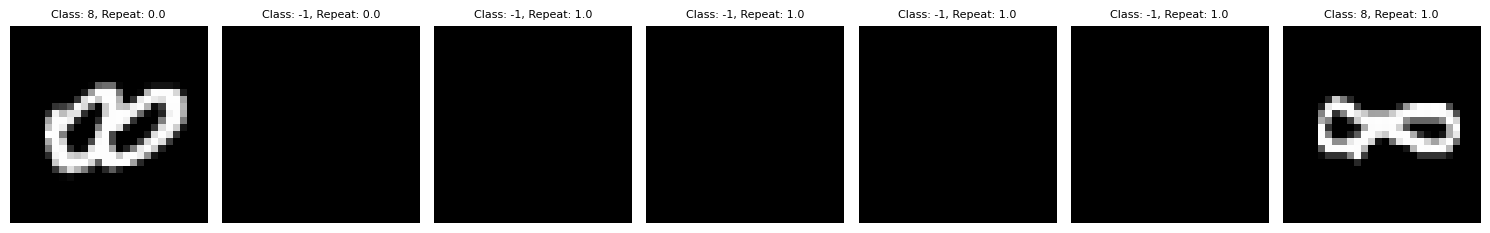

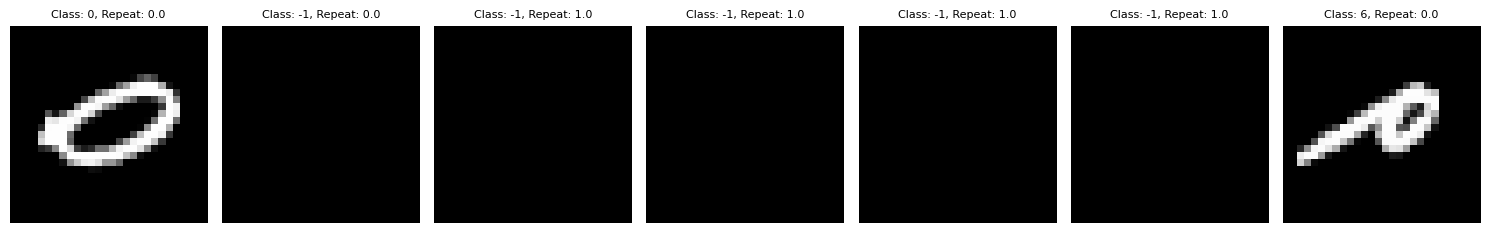


Testing data ...


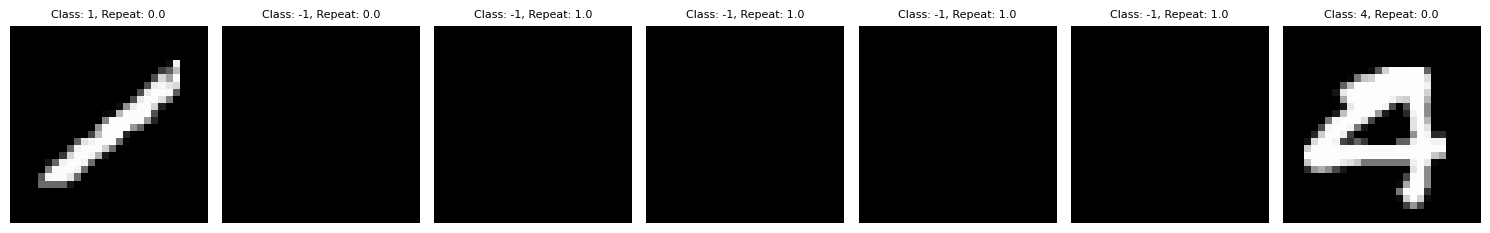

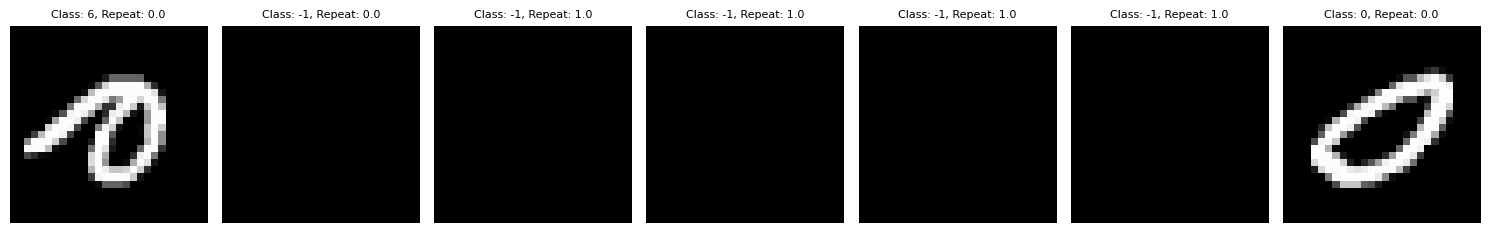


Validation data ...


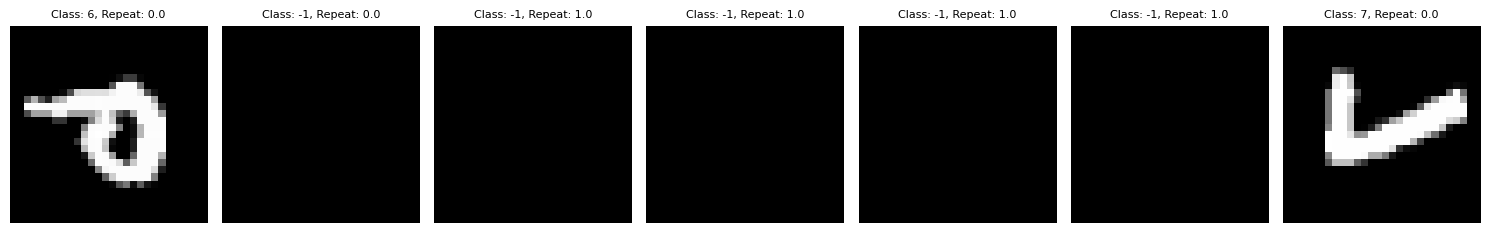

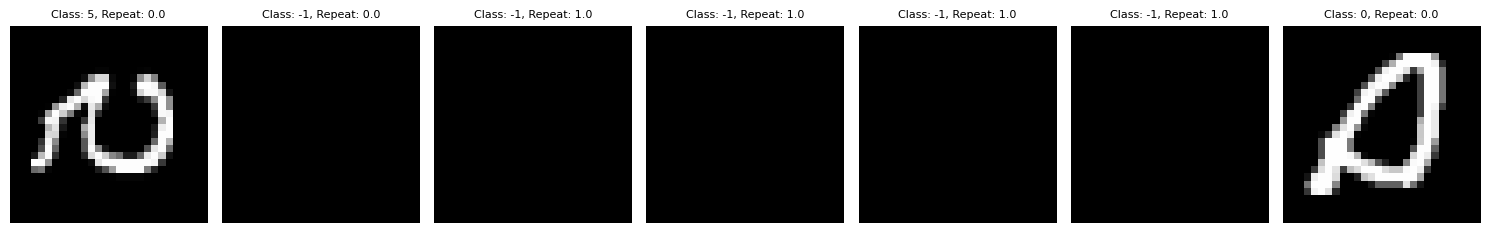

In [10]:
n_images_to_show = 2

# Visualize training, test and validation data
print("\nTraining data ...")
for sequences, class_labels, repeat_labels, match_labels in training_loader_MNIST:
    for i in range(n_images_to_show):
        show_sequence_task1_MNIST(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nTesting data ...")
for sequences, class_labels, repeat_labels, match_labels in testing_loader_MNIST:
    for i in range(n_images_to_show):
        show_sequence_task1_MNIST(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nValidation data ...")
for sequences, class_labels, repeat_labels, match_labels in  valid_loader_MNIST:
    for i in range(n_images_to_show):
        show_sequence_task1_MNIST(sequences[i], class_labels[i], repeat_labels[i])
    break  

## 2. Train the newly created architecture (ConvNet embedder > Working Memory model > Linear classifier per time step)